# Demo of building curve

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import curve
import curveman
import curveng
import cminstruments as inst

## Define instruments which we calibrate curves to

In [6]:
grids_fixed_ois = [7/365, 1/12, 2/12, 3/12, 6/12, 9/12, 1]
fixed_ois = [inst.ZeroRate(0, end, 'JPY-OIS') for end in grids_fixed_ois]
fixed_ois_rates = np.array([0.001, 0.001, 0.0015, 0.002, 0.0022, 0.003, 0.0035])

## Create CurveManager

In [7]:
cm = curveman.CurveManager()

## Define curves and register them to CurveManager

In [8]:
grids_ois = [7/365, 1/12, 0.4, 0.6, 1]
dfs_ois = np.ones((len(grids_ois), ))
ois_base = curve.Curve(grids_ois, dfs_ois, 'log_linear')
cm.append_curve('JPY-OIS-BASE', ois_base)

turn1_from = 0.2
turn1_to = 0.21
turn1_size = 0.0
turn1 = curve.TurnCurve(turn1_from, turn1_to, turn1_size)
cm.append_curve('JPY-Turn1', turn1)

turn2_from = 0.7
turn2_to = 0.71
turn2_size = 0.0
turn2 = curve.TurnCurve(turn2_from, turn2_to, turn2_size)
cm.append_curve('JPY-Turn2', turn2)

cm.register_basis_curve('JPY-OIS',
                        ['JPY-OIS-BASE', 'JPY-Turn1', 'JPY-Turn2'])

show the curves' degree of freedom

In [9]:
print(cm.get_grids())

[('JPY-OIS-BASE', 5), ('JPY-Turn1', 1), ('JPY-Turn2', 1)]


## Prepare loss function and create CurveEngine

In [12]:
loss = lambda xs, ys: np.sum((np.array(xs) - np.array(ys))**2)
ce = curveng.CurveEngine(cm,
                         fixed_ois,
                         loss)

## Build curve

In [14]:
%%time
cm = ce.build_curve(fixed_ois_rates)

CPU times: user 5.97 s, sys: 11.3 ms, total: 5.98 s
Wall time: 5.98 s


## show the accuracy of calibration 

In [15]:
print('market rates :', fixed_ois_rates)
evaluated = np.array([ois.par_rate(cm) for ois in fixed_ois])
print('calibrated ois :', evaluated)

market rates : [0.001  0.001  0.0015 0.002  0.0022 0.003  0.0035]
calibrated ois : [0.001  0.001  0.0015 0.002  0.0022 0.003  0.0035]


## Plot the forward curve

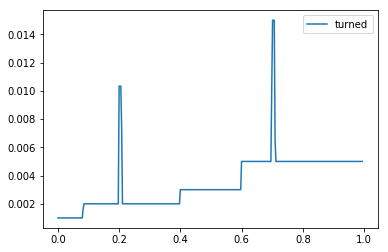

In [16]:
ts = np.arange(0, 1, 1/365)
df = cm.get_curve('JPY-OIS').get_df(ts)

fwd = -np.log(df[1:] / df[:-1]) / (ts[1:] - ts[:-1])
plt.plot(ts[:-1], fwd, label = 'turned')
plt.legend()
plt.show()